# Data Analysis Template Notebook

Welcome to the Data Analysis Template Notebook! This notebook constitue an example of how the data should be preproseed and analysed. It follows the pipelines reported in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html). Please do not hesitate to reach out to `#a-24-evaluation` if you have any questions or something in unclear.


<a id='Imports'></a>
## Imports set up

At the top of every notebook, we define an **Imports** section where all necessary packages and libraries should be imported. This ensures that all dependencies are loaded at the beginning of the notebook, making it easy to track what packages are in use.

In [ ]:
# General imports
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import glob          # For file searching
import re            # For pattern matching
import itertools

# Visualization imports
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical data visualization

# Display high-quality plots in SVG format
from IPython import display
display.set_matplotlib_formats('svg')  # Recommended for better plot quality

# to restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# display max numer of columns. Change the value as needed.
pd.set_option('display.max_columns', 100)

<ipython-input-1-3aa3f0fa1525>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')  # Recommended for better plot quality


<a id='Data-Loading'></a>
## Data Loading

In this section, we’ll use Google Drive to store and load datasets. The code below mounts Google Drive, finds all CSV files with a specified prefix in a given folder, and loads each CSV file into a dictionary of DataFrames for easy access.

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

folder_path = "/content/drive/MyDrive/Academies_DataAnalysis/July2024/DailySurveys/CN/students/"
file_prefix = "CN"  # Replace with your desired prefix

csv_files       = glob.glob(f"{folder_path}/{file_prefix}*.csv")
dataframes_dict = {file.split('/')[-1]: pd.read_csv(file) for file in csv_files}

# To access each DataFrame by filename, use the dictionary
# Example: Accessing the 'CSw1d1-Grid view.csv' file if it exists
dataframe_name = 'CNw1d1_modeltypes-Grid view.csv' # Adjust the filename to match your data
if dataframe_name in dataframes_dict:
    df = dataframes_dict[dataframe_name]
    print(df.head())  # Display the first 5 rows
else:
    print(f"{dataframe_name} not found in the loaded files.")
print('*' * 50)

# Print the loaded dataframes
print("Loaded DataFrames:", dataframes_dict.keys())
print('*' * 50)

# Check the number of datasets loaded
len(dataframes_dict)

Mounted at /content/drive
                                    uid                  pod  \
0  460e8e18-a82f-4026-ba32-bf99986edc20  Elegant Alstromeria   
1  ea3804d9-c8c4-40ce-8b1f-59c19b7f957c   Faithful Monbretia   
2  06772e99-1749-426b-9fd7-76f272c557c6      Confident Malva   
3  8d6681ef-5f7a-4af9-84d3-abaa30c25f10      Confident Malva   
4  1592e2c5-795c-427b-82bf-1c9d8d891bb4      Confident Malva   

   pod_name (from pod) content-score Q1  Q1-score Q2  Q2-score Q3  Q3-score  \
0  Elegant Alstromeria           33%  A         0  D         0  D         1   
1   Faithful Monbretia            0%  A         0  B         0  C         0   
2      Confident Malva          100%  B         1  C         1  D         1   
3      Confident Malva          100%  B         1  C         1  D         1   
4      Confident Malva           33%  A         0  B         0  D         1   

   PodDynamics  TAcomms LastQ  \
0            2        4   NaN   
1            4        5   NaN   
2            3 

15

<a id='Data-Cleaning-and-Preprocessing'></a>
## Data Cleaning and Preprocessing

The below function can be used for cleaning students daily surveys. Please find detailed explanations of it in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html).

In [ ]:
def clean_and_combine_data(
    dataframes_dict,
    ST_apps_path,
    course_id,
    status,
    TAs_apps_path,
    output_file='combined_df.csv'
):
    """
    Cleans and combines dataframes, checks UID validity, handles duplicates,
    and saves the final combined dataframe.

    Parameters:
    - dataframes_dict: Dictionary with filenames as keys and DataFrames as values.
    - ST_apps_path: Path to the ST_apps dataset CSV file.
    - course_id: Course ID to filter the ST_apps dataset.
    - status: Status to filter the ST_apps dataset.
    - TAs_apps_path: Path to the TAs_apps dataset CSV file.
    - output_file: Filename to save the cleaned combined dataframe (default: 'combined_df.csv').
    """

    # Step 1: Add "WeekDay" column based on the filename pattern
    for filename, df in dataframes_dict.items():
        match = re.search(r'w\d+d\d+', filename, re.IGNORECASE)
        if match:
            df['WeekDay'] = match.group()
        else:
            print(f"No 'WeekDay' pattern found in filename: {filename}")

    # Step 2: Combine all DataFrames
    combined_df = pd.concat(dataframes_dict.values(), ignore_index=True)
    print("[INFO] Successfully combined all dataframes.")
    print(f"       Combined DataFrame shape: {combined_df.shape}")
    print('-' * 80)

    # Step 3: Load ST_apps (full) and TAs_apps, then filter ST_apps by course_id and status
    ST_apps = pd.read_csv(ST_apps_path)
    TAs_apps = pd.read_csv(TAs_apps_path)

    ST_apps_filtered = ST_apps[
        (ST_apps['course_id'] == course_id) &
        (ST_apps['application_status'] == status)
    ]
    print("[INFO] Filtered ST_apps based on specified course_id and status.")
    print(f"       Filtered ST_apps shape: {ST_apps_filtered.shape}")
    print('-' * 80)
    print()

    # Step 4: Identify UIDs in combined_df that are NOT in ST_apps_filtered
    missing_values = combined_df.loc[
        ~combined_df['uid'].isin(ST_apps_filtered['unique_id']), 'uid'
    ].unique()

    if missing_values.size > 0:
        print(f"[WARNING] Found {len(missing_values)} UID(s) in combined_df not present in ST_apps_filtered.")
        print("          Missing UIDs:")
        print("          ", missing_values)
        print('-' * 80)

        # 4A: Check these missing UIDs in the FULL ST_apps
        print("[INFO] Checking the FULL(not filtered) ST_apps dataset for these missing UIDs...")
        print("       They may exist under different statuses or different courses")
        missing_in_ST_full = ST_apps[ST_apps['unique_id'].isin(missing_values)]
        found_uids_ST = missing_in_ST_full['unique_id'].unique()

        if found_uids_ST.size > 0:
            print("[INFO] Some of the missing UIDs were found in the FULL ST_apps dataset:")
            for uid in found_uids_ST:
                uid_rows = missing_in_ST_full.loc[
                    missing_in_ST_full['unique_id'] == uid,
                    ['application_status', 'course_id']
                ]
                statuses = uid_rows['application_status'].unique()
                course_ids = uid_rows['course_id'].unique()
                print(f"  UID = {uid}, status = {list(statuses)}, course_id = {list(course_ids)}")


        # 4B: After ST check, see which UIDs remain missing
        print('-' * 80)
        print()
        print("[INFO] Determining which UIDs remain missing.")
        print("       This is done by calculating: set(missing_values) - set(found_uids_ST).")
        still_missing_after_ST = set(missing_values) - set(found_uids_ST)
        if len(still_missing_after_ST) > 0:
            print("[WARNING] The following UIDs are still missing:")
            print(f"          {still_missing_after_ST}")
            print('-' * 80)
            print()

            # Now check the still-missing UIDs in TAs_apps
            print("[INFO] Checking the TA dataset as maybe these uids are associated with TAs")
            missing_in_TAs = TAs_apps[TAs_apps['unique_id'].isin(still_missing_after_ST)]
            found_uids_TAs = missing_in_TAs['unique_id'].unique()

            if found_uids_TAs.size > 0:
                print("[WARNING] The following UIDs are found in the TAs_apps dataset:")
                for uid in found_uids_TAs:
                    uid_rows = missing_in_TAs.loc[
                        missing_in_TAs['unique_id'] == uid,
                        ['status', 'course_id']
                    ]
                    statuses = uid_rows['status'].unique()
                    course_ids = uid_rows['course_id'].unique()
                    print(f"  UID = {uid}, status = {list(statuses)}, course_id = {list(course_ids)}")

            # UIDs not found anywhere (neither in full ST nor TAs)
            print('-' * 80)
            print()
            not_found_anywhere = still_missing_after_ST - set(found_uids_TAs)
            if not_found_anywhere:
                print(f"[WARNING] The following {len(not_found_anywhere)} UIDs were NOT found in ST_apps_filtered, FULL ST_apps, or TAs_apps:")
                print(f"          {not_found_anywhere}")
        else:
            # If nothing left after the ST check, skip TAs_apps checks
            found_uids_TAs = []

        # Finally, remove rows from combined_df that are NOT in ST_apps_filtered
        print('-' * 80)
        print()
        combined_df = combined_df[combined_df['uid'].isin(ST_apps_filtered['unique_id'])]
        print("[INFO] Removed rows with missing UIDs that are not in the filtered list.")
        print("New shape:", combined_df.shape)
        print('-' * 80)
        print()

    # Step 5: Check for duplicates within each WeekDay and UID combination
    duplicates = combined_df[combined_df.duplicated(subset=['WeekDay', 'uid'], keep=False)]
    if not duplicates.empty:
        print(f"[INFO] Duplicate rows found based on ['WeekDay', 'uid']: {len(duplicates)}")
        combined_df = combined_df.drop_duplicates(subset=['WeekDay', 'uid'], keep='first')
        print("[INFO] Removed duplicates. New shape:", combined_df.shape)
        print('-' * 80)
        print()

    # Step 6: Save the cleaned DataFrame to CSV
    combined_df.to_csv(output_file, index=False)
    print(f"[INFO] Cleaned DataFrame saved to {output_file}")

    return combined_df

In [ ]:
combined_df = clean_and_combine_data(
    dataframes_dict=dataframes_dict,
    ST_apps_path="/content/drive/MyDrive/Academies_DataAnalysis/General/Students_ReceivedApp_from2021.csv", # to be updated in 2025
    course_id=12,       # Specify the course_id number of interest
    status="matched",   # Do NOT change the status
    TAs_apps_path = "/content/drive/MyDrive/Academies_DataAnalysis/General/TAs_ReceivedApp_from2021.csv",
    output_file="cleaned_combined_df.csv"
)


[INFO] Successfully combined all dataframes.
       Combined DataFrame shape: (4488, 29)
--------------------------------------------------------------------------------
[INFO] Filtered ST_apps based on specified course_id and status.
       Filtered ST_apps shape: (1045, 24)
--------------------------------------------------------------------------------

[WARNING] Found 16 UID(s) in combined_df not present in ST_apps_filtered.
          Missing UIDs:
           ['31da3c4f-01f2-4f04-8f6b-aef346f2edf0'
 'ec8eb03c-3e65-40d1-925a-e06171e1e03c'
 '4627376e-8d7e-4276-ac84-a62763889472'
 'e571845d-0a7a-4863-a8a9-9c3b238457b9'
 'cb51655a-b50b-472b-9d42-8118942cdd59'
 '0f326e1b-17ff-455f-a1f7-25cc379ae595'
 '548fd4a5-6eaa-4efa-be1d-0561ce9a5a6c'
 '0f9fe91c-a90f-4161-bd27-387f851062b6' '669'
 'd4cfc2c0-e4c6-4e2c-b865-4faa1817f416'
 '41e5afe1-d450-4bcc-b679-a13e9d4a59c5'
 '2b92f269-49fc-4492-9cdd-700c9ec6d3c4'
 'cd343d48-fafd-4158-b503-cb83590a5f05'
 'b6163afa-7e10-40ad-b8ec-db2fd50994e2'
 '8a35

**View the first and last 5 rows of the dataset**

In [ ]:
combined_df.head()

,uid,pod,pod_name (from pod),content-score,Q1,Q1-score,Q2,Q2-score,Q3,Q3-score,PodDynamics,TAcomms,LastQ,which_section,Code of conduct,Podmates,ta_access_to_data,WeekDay,Q4-score,Q5-score,Q6-score,Q7-score,Q8-score,Q9-score,TAconcerns,goal1_intermediate,goal2_intermediate,goal3_intermediate,Project TA
0,460e8e18-a82f-4026-ba32-bf99986edc20,Elegant Alstromeria,Elegant Alstromeria,33%,A,0.00,D,0.00,D,1.00,2,4,NaN,04 T1 Section 5: Reflecting on what models,A,NaN,B,w1d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ea3804d9-c8c4-40ce-8b1f-59c19b7f957c,Faithful Monbretia,Faithful Monbretia,0%,A,0.00,B,0.00,C,0.00,4,5,NaN,14 T3 Bonus Section 1: The foundations for En...,A,"Messi, Carmen Tang, Saameh Samaaee",A,w1d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06772e99-1749-426b-9fd7-76f272c557c6,Confident Malva,Confident Malva,100%,B,1.00,C,1.00,D,1.00,3,4,NaN,14 T3 Bonus Section 1: The foundations for En...,A,"Bobi Bao, Andrew Kwok, Soumyajit Bose",C,w1d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8d6681ef-5f7a-4af9-84d3-abaa30c25f10,Confident Malva,Confident Malva,100%,B,1.00,C,1.00,D,1.00,4,5,NaN,13 T3 Section 4: Reflecting on why models,A,"Vaibhavi, Jingyi, Jianwen",C,w1d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1592e2c5-795c-427b-82bf-1c9d8d891bb4,Confident Malva,Confident Malva,33%,A,0.00,B,0.00,D,1.00,4,5,NaN,13 T3 Section 4: Reflecting on why models,B,"Soumyajit bose, jinwen, jingyi",B,w1d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
combined_df.tail()

,uid,pod,pod_name (from pod),content-score,Q1,Q1-score,Q2,Q2-score,Q3,Q3-score,PodDynamics,TAcomms,LastQ,which_section,Code of conduct,Podmates,ta_access_to_data,WeekDay,Q4-score,Q5-score,Q6-score,Q7-score,Q8-score,Q9-score,TAconcerns,goal1_intermediate,goal2_intermediate,goal3_intermediate,Project TA
4478,cb14ea9e-1b27-4200-87b5-ca907a4184ac,Stellar Goldenrod,NaN,88%,NaN,0.00,NaN,1.00,NaN,1.00,4,5,NaN,T4 Section 4: Thinking about causality in your...,NaN,NaN,NaN,w3d5,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,"A,C,E,F"
4479,41035d9c-3aae-493d-bce1-5756001cde31,Hopeful Rondeletia,NaN,88%,NaN,0.00,NaN,1.00,NaN,1.00,5,5,NaN,T4 Section 4: Thinking about causality in your...,NaN,NaN,NaN,w3d5,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,"A,B,C,D,E,F,G"
4480,a4928c2d-9dcb-4ee5-a65a-9c4aaee5decf,Agreeable Lobelia,NaN,88%,NaN,0.00,NaN,1.00,NaN,1.00,5,5,NaN,T4 Section 4: Thinking about causality in your...,NaN,NaN,NaN,w3d5,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,"A,B"
4482,212c8c42-5b87-48b3-9c5a-b62a1a7e43d9,Hopeful Rondeletia,NaN,88%,NaN,0.00,NaN,1.00,NaN,1.00,4,5,NaN,T4 Section 1: Instrumental variables,NaN,NaN,NaN,w3d5,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,"A,B,C,D,E,F,G"
4487,2e532116-5361-4207-8e0e-afb60d160794,Zealous Sedum,NaN,88%,NaN,0.00,NaN,1.00,NaN,1.00,5,5,NaN,T4 Section 4: Thinking about causality in your...,NaN,NaN,NaN,w3d5,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,"A,C,D"


**Understand the shape of the dataset**

In [ ]:
print("There are", combined_df.shape[0], 'rows and', combined_df.shape[1], "columns.")

There are 4355 rows and 29 columns.


**Check the data types of the columns in the dataset**

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4355 entries, 0 to 4487
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   uid                  4355 non-null   object 
 1   pod                  4349 non-null   object 
 2   pod_name (from pod)  461 non-null    object 
 3   content-score        4238 non-null   object 
 4   Q1                   465 non-null    object 
 5   Q1-score             4238 non-null   float64
 6   Q2                   465 non-null    object 
 7   Q2-score             4238 non-null   float64
 8   Q3                   465 non-null    object 
 9   Q3-score             4238 non-null   float64
 10  PodDynamics          4355 non-null   int64  
 11  TAcomms              4355 non-null   int64  
 12  LastQ                642 non-null    object 
 13  which_section        3917 non-null   object 
 14  Code of conduct      452 non-null    object 
 15  Podmates             420 non-null    object

In [ ]:
# combined_df.describe().T
combined_df.describe(include = 'all').T # if you want to include object too

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uid,4355,578,460e8e18-a82f-4026-ba32-bf99986edc20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pod,4349,71,Energetic Xerophyllum,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pod_name (from pod),461,68,Energetic Xerophyllum,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content-score,4238,23,100%,858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q1,465,5,B,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q1-score,4238.00,NaN,NaN,NaN,0.65,0.48,0.00,0.00,1.00,1.00,1.00
Q2,465,5,C,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q2-score,4238.00,NaN,NaN,NaN,0.64,0.48,0.00,0.00,1.00,1.00,1.00
Q3,465,5,D,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3-score,4238.00,NaN,NaN,NaN,0.61,0.49,0.00,0.00,1.00,1.00,1.00


# Function to define colors for plotting

In [ ]:
# Define colors

colors_cma = [
    "#313f76",
    "#a2bbd4",
    "#67ada9",
    "#e18256",
    "#596a63",
    "#f0ba7d"]

colors_nma = [
    "#D18D20",
    "#FF7676",
    "#008CBF",
    "#43439E"]

# Option to choose between sets
def get_colors(name="CMA"):
    """
    Returns a list of colors based on the name provided.
    Supported values:
    - "CMA" for CMA colors
    - "NMA" for NMA colors
    - "ALL" for both CMA and NMA colors combined
    """
    if name.upper() == "CMA":
        return colors_cma
    elif name.upper() == "NMA":
        return colors_nma
    elif name.upper() == "ALL":
        return colors_cma + colors_nma
    else:
        raise ValueError("Invalid color set name. Use 'CMA', 'NMA', or 'ALL'.")

# Examples of usage:
# cma_colors = get_colors("CMA")   # CMA-only colors
# nma_colors = get_colors("NMA")   # NMA-only colors
# all_colors = get_colors("ALL")   # All colors combined

# Score questions

1. Q-score questions --> Each day students answer questions related to the material learned during the day. Automatically the survey assigns 0 if the answer is wrong and 1 if the answer is correct.

2. content-score --> calculate the percentage of the correct answers. We can focus on this column and ingore the Q-score questions


In [ ]:
combined_df['content-score'].dtype

dtype('O')

In [ ]:
combined_df['content-score'].unique()

array(['33%', '0%', '100%', '67%', '89%', '44%', '56%', '78%', '22%',
       '11%', '83%', '50%', '17%', '40%', '60%', '20%', '80%', '75%',
       '88%', '63%', '13%', '38%', '25%', nan], dtype=object)

**Content score is object type. We want to remove the percentage symbol and change type to numeric.**

However, from combined_df.info() we saw that we have missing values in this column. Let's check where these NaNs are.

In [ ]:
combined_df['content-score'].isnull().sum()

117

In [ ]:
# Check in which day(s) we have missing values
missing_score = combined_df.groupby('WeekDay')['content-score'].apply(lambda x: x.isnull().sum())
print(missing_score)

WeekDay
w1d1      0
w1d2      0
w1d3      0
w1d4      0
w1d5      0
w2d1      0
w2d2      0
w2d3      0
w2d4      0
w2d5    117
w3d1      0
w3d2      0
w3d3      0
w3d4      0
w3d5      0
Name: content-score, dtype: int64


**We dont have content questions for project days. Project day in CN is W2D1 and W2D5.** Please note that even if W2D1 is project day, evaluation question are asked.

We can move forward filtering out NaNs.

In [ ]:
print(len(combined_df['content-score']))

# Create a filtered copy
combined_df_filtered = combined_df[combined_df['content-score'].notna()].copy()
print(len(combined_df_filtered['content-score']))

4355
4238


In [ ]:
combined_df_filtered['content-score'] = combined_df_filtered['content-score'].str.replace('%', '').astype(float)

In [ ]:
combined_df_filtered.groupby('WeekDay')['content-score'].mean()

,content-score
WeekDay,
w1d1,59.06
w1d2,68.91
w1d3,88.84
w1d4,79.95
w1d5,72.71
w2d1,55.40
w2d2,61.55
w2d3,24.91
w2d4,40.08


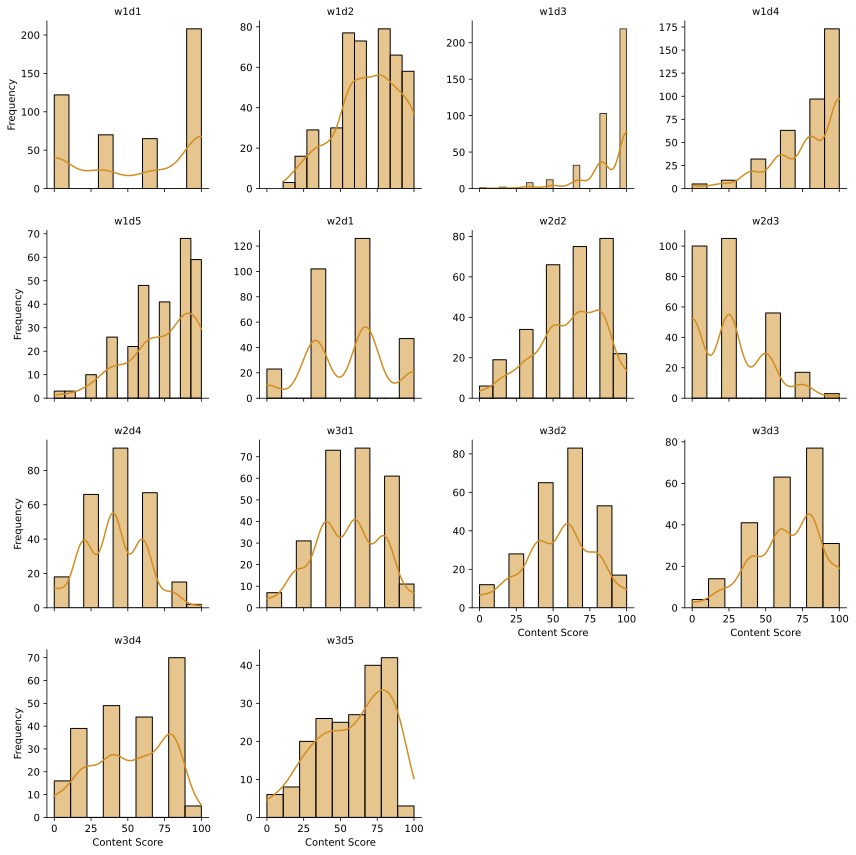

In [ ]:
colors = get_colors("NMA")

Histogram = sns.FacetGrid(combined_df_filtered, col="WeekDay", col_wrap=4, sharex=True, sharey=False)
Histogram.map(sns.histplot, "content-score", kde=True, color=colors[0])

Histogram.set_axis_labels("Content Score", "Frequency")
Histogram.set_titles("{col_name}")  # Show the column name as the title for each subplot

plt.show()

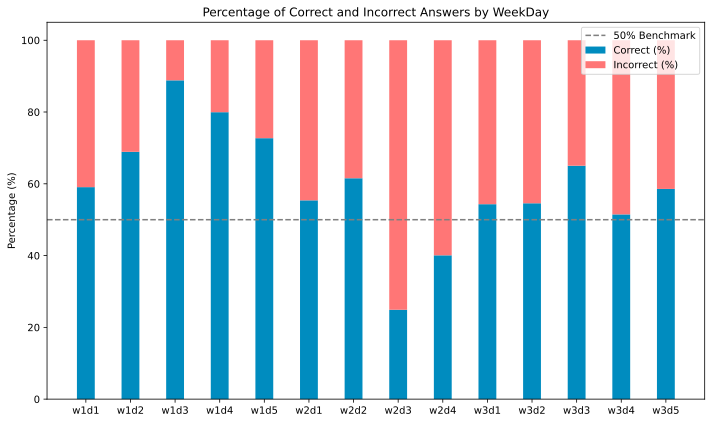

In [ ]:
palette_colors = get_colors("NMA")

# Choose the first two colors for correct and incorrect bars
color_correct = palette_colors[2]  # e.g., third color in NMA
color_incorrect = palette_colors[1]  # e.g., second color in NMA

weekday_stats = combined_df_filtered.groupby('WeekDay')['content-score'].mean().reset_index()
weekday_stats['Incorrect'] = 100 - weekday_stats['content-score']

# Sort WeekDays
weekday_stats = weekday_stats.sort_values('WeekDay')

# Plotting with a line at y=50%
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4  # Bar width

# Bar plots for correct and incorrect
ax.bar(
    weekday_stats['WeekDay'],
    weekday_stats['content-score'],
    width,
    label='Correct (%)',
    color=color_correct)

ax.bar(
    weekday_stats['WeekDay'],
    weekday_stats['Incorrect'],
    width,
    bottom=weekday_stats['content-score'],
    label='Incorrect (%)',
    color=color_incorrect)

# Adding a horizontal line at y=50%
ax.axhline(50, color='grey', linestyle='--', linewidth=1.5, label='50% Benchmark')

# Adding labels and title
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('')
ax.set_title('Percentage of Correct and Incorrect Answers by WeekDay')
ax.legend()

plt.tight_layout()
plt.savefig('Content_score.png', dpi=400)
plt.show()


**Obersvations**


*   w2d3 and w2d4 less than 50% of answers were correct. w2d3 = 24.91% correct and w2d4 =	40.08% correct.  
*   On w3d1, w3d2, and w3d4, scores hover around the 50% mark.

These results suggest that certain daily questions may benefit from further review.



# Pod Dynamics

In the daily surveys for each course students rate the pod Dymanics using a Likert scale from `1 = I am having a terrible time! Please help!` to
`5 - Everything is going great!`

Let's check how the PodDymanic changed during the course.

Remeber that we have seen from `combined_df.info()` that PodDynamics has zero non-null values and it's of type `int64`

In [ ]:
PodDyn_perc = combined_df.groupby('WeekDay')['PodDynamics'].value_counts(normalize=True) * 100
print(PodDyn_perc)

WeekDay  PodDynamics
w1d1     4             35.27
         5             34.62
         3             23.23
         2              5.81
         1              1.08
                        ... 
w3d5     5             72.59
         4             18.78
         3              6.09
         2              2.03
         1              0.51
Name: proportion, Length: 67, dtype: float64


In [ ]:
PodDyn = combined_df['PodDynamics'].value_counts(normalize=True) * 100
print(PodDyn)

PodDynamics
5   52.28
4   30.17
3   14.03
2    3.24
1    0.28
Name: proportion, dtype: float64


WeekDay
w1d1    465
w1d2    431
w1d3    377
w1d4    379
w1d5    280
w2d1    298
w2d2    301
w2d3    281
w2d4    261
w2d5    117
w3d1    257
w3d2    258
w3d3    230
w3d4    223
w3d5    197
Name: uid, dtype: int64


<ipython-input-37-19bc7b326f2a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='WeekDay', y='PodDynamics', palette="coolwarm")


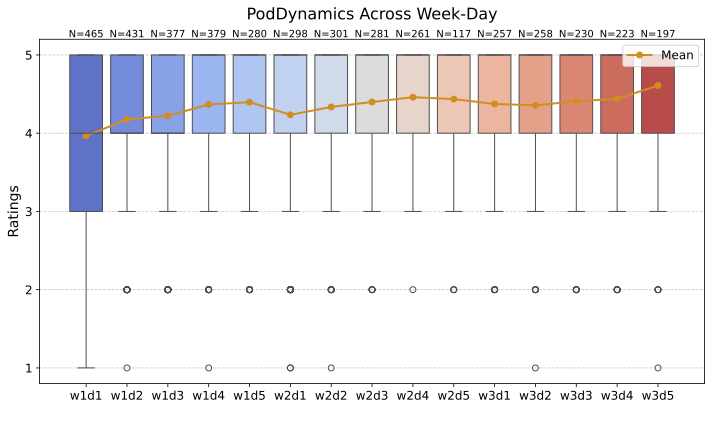

In [ ]:
mean_values = combined_df.groupby('WeekDay')['PodDynamics'].mean()

# Group by WeekDay and count unique uids
uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()
print(uids_answered_per_weekday)

colors = get_colors("NMA")

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='WeekDay', y='PodDynamics', palette="coolwarm")

# Add a line for the mean
plt.plot(mean_values.index, mean_values.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate the number of uids at the top of each boxplot
for i, (weekday, count) in enumerate(uids_answered_per_weekday.items()):
    plt.text(i,  # x-coordinate: position of the boxplot (aligned with xticks)
             5.2,  # y-coordinate: position above the maximum y-value (adjust as needed)
             f'N={count}',  # Text to display
             ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title("PodDynamics Across Week-Day", fontsize=16, pad=20)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('Poddynamics.png', dpi=400)
plt.show()

#files.download('Poddynamics.png')

**Obersvations**

- Day 1 is the day that has the highest variability in ratings probably because students need time to know their pod peers.
- The general trend goes up during the weeks and overall Pod Dynamics is rated as 4 or 5 by over 80% of students.  

# TA communication

In the daily surveys for each course students rate the TA communication using a Likert scale from `1 = I do not feel comfortable talking to my TA at all` to
`5 - I can talk to my TA easily`

Let's check how the TAcomms changed during the course.

Remeber that we have seen from `combined_df.info()` that TAcomms has zero non-null values and it's of type `int64`

In [ ]:
TAcomm_perc = combined_df.groupby('WeekDay')['TAcomms'].value_counts(normalize=True) * 100
print(TAcomm_perc)

WeekDay  TAcomms
w1d1     5         62.15
         4         23.23
         3         10.11
         2          4.09
         1          0.43
                    ... 
w3d4     2          2.24
w3d5     5         80.71
         4         13.20
         3          4.57
         2          1.52
Name: proportion, Length: 71, dtype: float64


In [ ]:
TAcomm = combined_df['TAcomms'].value_counts(normalize=True) * 100
print(TAcomm)

TAcomms
5   67.74
4   21.49
3    7.97
2    2.18
1    0.62
Name: proportion, dtype: float64


WeekDay
w1d1    465
w1d2    431
w1d3    377
w1d4    379
w1d5    280
w2d1    298
w2d2    301
w2d3    281
w2d4    261
w2d5    117
w3d1    257
w3d2    258
w3d3    230
w3d4    223
w3d5    197
Name: uid, dtype: int64


<ipython-input-38-2d40805e6aaf>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='WeekDay', y='TAcomms', palette="coolwarm")


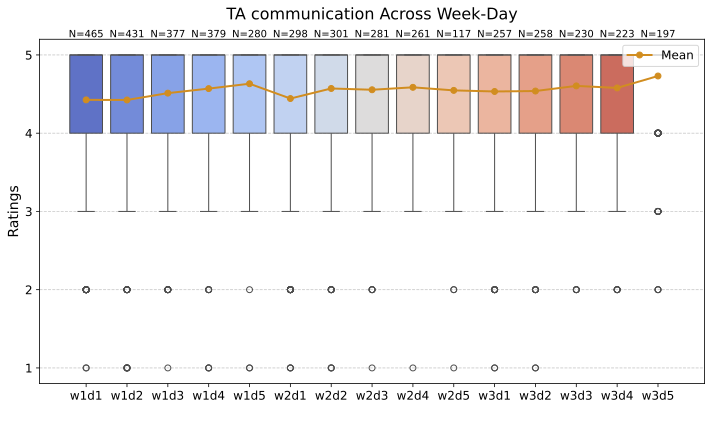

In [ ]:
mean_valuesTA = combined_df.groupby('WeekDay')['TAcomms'].mean()

# Group by WeekDay and count unique uids
uids_answered_per_weekdayTA = combined_df.groupby('WeekDay')['uid'].nunique()
print(uids_answered_per_weekdayTA)

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='WeekDay', y='TAcomms', palette="coolwarm")

# Add a line for the mean
plt.plot(mean_valuesTA.index, mean_valuesTA.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate the number of uids at the top of each boxplot
for i, (weekday, count) in enumerate(uids_answered_per_weekdayTA.items()):
    plt.text(i,  # x-coordinate: position of the boxplot (aligned with xticks)
             5.2,  # y-coordinate: position above the maximum y-value (adjust as needed)
             f'N={count}',  # Text to display
             ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title("TA communication Across Week-Day", fontsize=16, pad=20)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('TAcomms.png', dpi=400)
plt.show()

#files.download('TAcomms.png')

**Obersvations**

- The general trend for TAs communication is relatively stable with high ratings. Over 80% of students rated thei communications with the TAs as either 4 or 5.   

# Which Section

In the which_section students report where they stopped each day. This question was not mandatory until 2024, but it will be from 2025.

During project day (for CN is W2D1 and W2D5) this question is not asked.

Sections comprise mandatory and bonus material.


In [ ]:
combined_df.groupby('WeekDay')['which_section'].count()

,which_section
WeekDay,
w1d1,465
w1d2,431
w1d3,377
w1d4,379
w1d5,280
w2d1,0
w2d2,301
w2d3,281
w2d4,261


## Plot the percentage of students stopping at each section by WeekDay.

This includes mandatory and bonus material.

In [ ]:
unique_weekdays = sorted(combined_df['WeekDay'].dropna().unique())

# Shorten the names in 'which_section' for better plotting
combined_df['short_section'] = combined_df['which_section'].apply(lambda x: x[3:14] if isinstance(x, str) else x)

# Step 2: Extract the count of students who stopped at each shortened section per 'WeekDay'
short_section_counts = combined_df.groupby(['WeekDay', 'short_section']).size().reset_index(name='count')

# Step 3: Calculate percentages for each shortened section per 'WeekDay'
weekday_totals = short_section_counts.groupby('WeekDay')['count'].transform('sum')
short_section_counts['percentage'] = (short_section_counts['count'] / weekday_totals) * 100

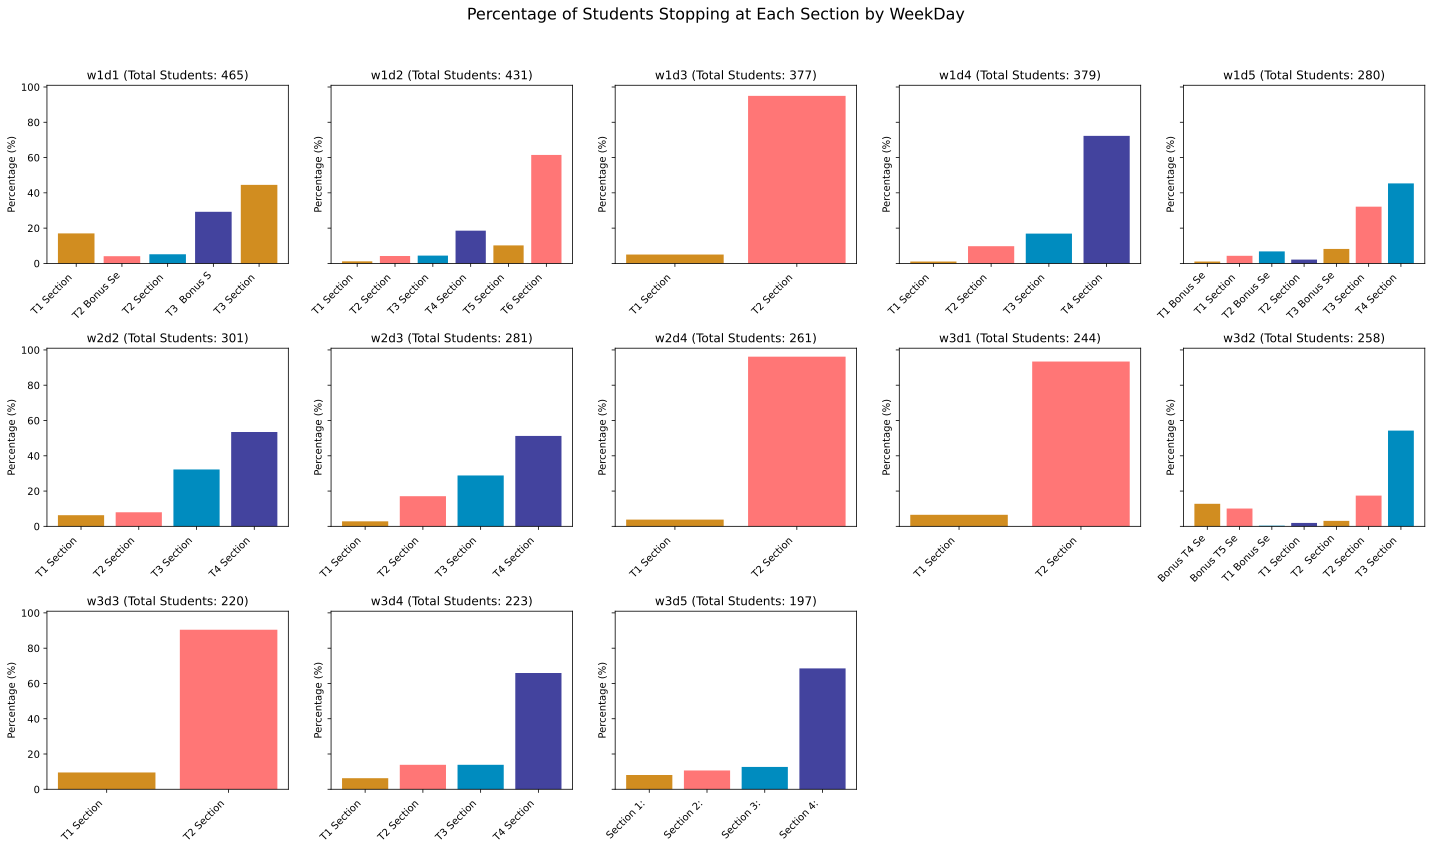

In [ ]:
valid_weekdays = short_section_counts['WeekDay'].unique()

# Calculate the total number of students (uIDs) for each WeekDay
total_students_per_weekday = short_section_counts.groupby('WeekDay')['count'].sum()

# Create a grid dynamically based on the number of valid weekdays
rows = (len(valid_weekdays) + 4) // 5  # Adjust rows for up to 5 plots per row
fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 4), sharey=True)
axes = axes.flatten()

# Loop through valid WeekDays and plot
for idx, weekday in enumerate(valid_weekdays):
    # Filter data for the specific WeekDay
    weekday_data = short_section_counts[short_section_counts['WeekDay'] == weekday]
    total_students = total_students_per_weekday[weekday]  # Total students for this day

    # Bar plot for the specific WeekDay
    axes[idx].bar(weekday_data['short_section'], weekday_data['percentage'], color=colors)
    axes[idx].set_title(f"{weekday} (Total Students: {total_students})")
    axes[idx].set_xticks(range(len(weekday_data['short_section'])))
    axes[idx].set_xticklabels(weekday_data['short_section'], rotation=45, ha='right')
    axes[idx].set_ylabel('Percentage (%)')

# Hide any unused subplots
for i in range(len(valid_weekdays), len(axes)):
    axes[i].axis('off')

# Add a main title
fig.suptitle('Percentage of Students Stopping at Each Section by WeekDay', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()


## Plot the daily distribution without dividing by tutorial sections.

This includes mandatory and bonus material.

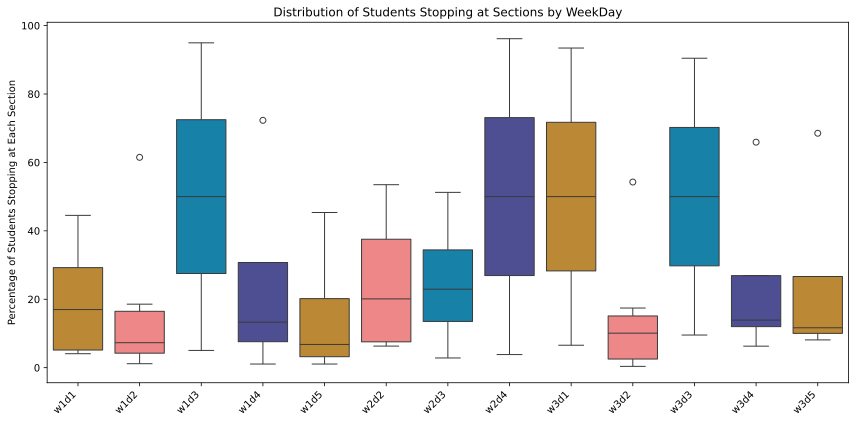

In [ ]:
boxplot_data = []
weekdays = sorted(short_section_counts['WeekDay'].unique())

# Extend the colors by cycling through them
extended_colors = list(itertools.islice(itertools.cycle(colors), len(weekdays)))

# Loop through each weekday and extract percentages
for weekday in weekdays:
    data = short_section_counts[short_section_counts['WeekDay'] == weekday]['percentage'].values
    boxplot_data.append(data)

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_data, palette=extended_colors)

# Set labels and formatting
plt.xticks(ticks=range(len(weekdays)), labels=weekdays, rotation=45, ha='right')
plt.ylabel("Percentage of Students Stopping at Each Section")
plt.title("Distribution of Students Stopping at Sections by WeekDay")
plt.tight_layout()

# Show plot
plt.show()


## Plot Bonus Sections

In [ ]:
bonus_rows = combined_df[combined_df['which_section'].str.contains('Bonus', case=False, na=False)]

In [ ]:
bonus_counts = bonus_rows.groupby('WeekDay').size().reset_index(name='count')
bonus_counts

,WeekDay,count
0,w1d1,155
1,w1d5,45
2,w3d2,60


**For CN not all bonus sections are defined. We might change it in 2025. Please plot the bonus sections if data is available.**

## Plot mandatory sections

**Recalculate removing rows where 'which_section' contains the word 'Bonus' (case insensitive) as Bonus sections are not mandatory**

In [ ]:
bonus_rows = combined_df[combined_df['short_section'].str.contains('Bonus', case=False, na=False)]
bonus_rows

# Remove rows where 'which_section' contains the word 'Bonus' (case insensitive)
filtered_df = combined_df[~combined_df['short_section'].str.contains('Bonus', case=False, na=False)]

In [ ]:
short_section_counts = filtered_df.groupby(['WeekDay', 'short_section']).size().reset_index(name='count')

# Calculate percentages for each shortened section per 'WeekDay'
weekday_totals = short_section_counts.groupby('WeekDay')['count'].transform('sum')
short_section_counts['percentage'] = (short_section_counts['count'] / weekday_totals) * 100

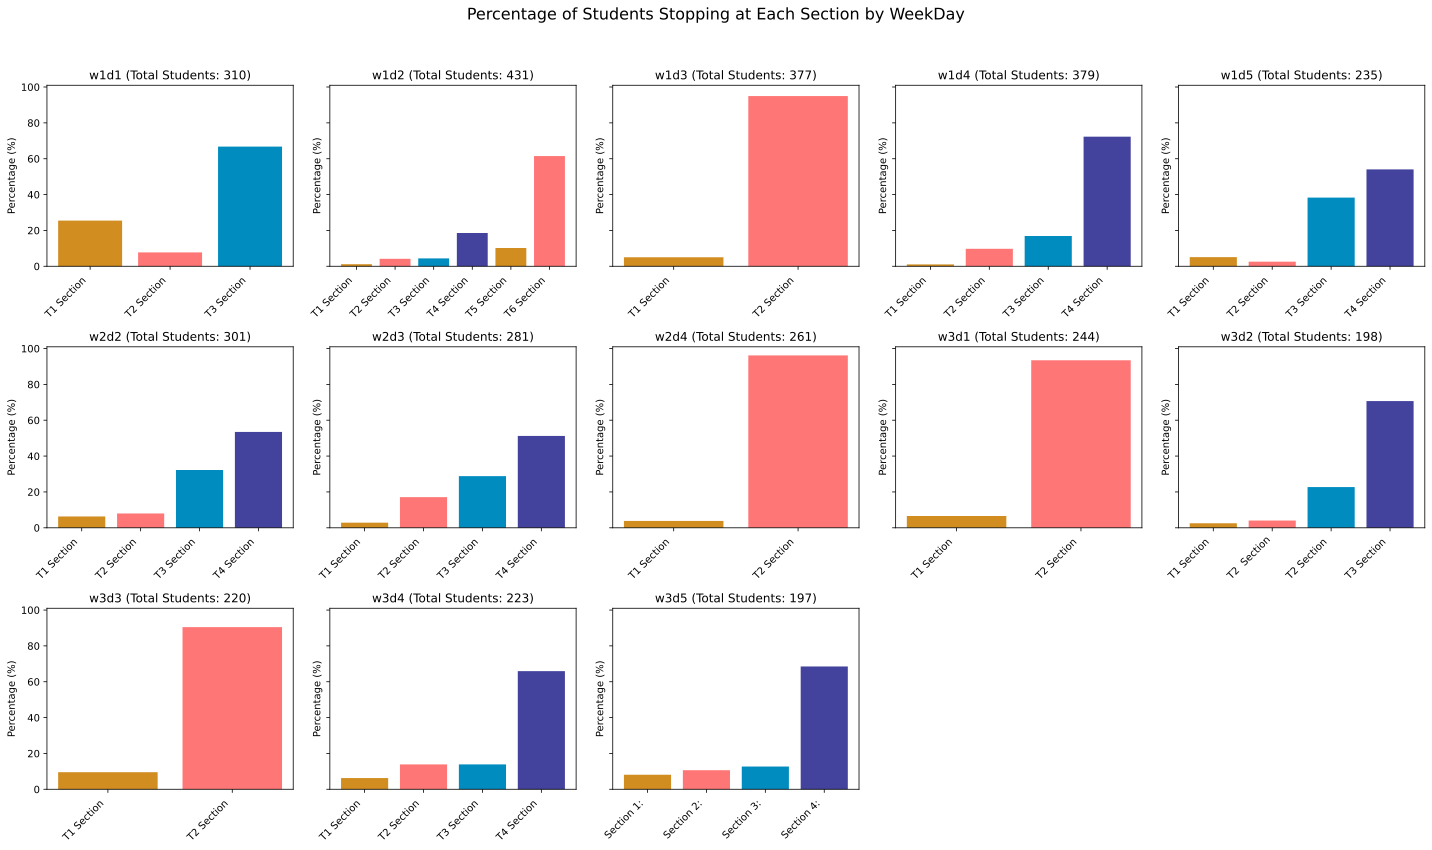

In [ ]:
# Calculate the total number of students (uIDs) for each WeekDay
total_students_per_weekday = short_section_counts.groupby('WeekDay')['count'].sum()

# Create a grid dynamically based on the number of valid weekdays
rows = (len(valid_weekdays) + 4) // 5  # Adjust rows for up to 5 plots per row
fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 4), sharey=True)
axes = axes.flatten()

# Loop through valid WeekDays and plot
for idx, weekday in enumerate(valid_weekdays):
    # Filter data for the specific WeekDay
    weekday_data = short_section_counts[short_section_counts['WeekDay'] == weekday]
    total_students = total_students_per_weekday[weekday]  # Total students for this day

    # Bar plot for the specific WeekDay
    axes[idx].bar(weekday_data['short_section'], weekday_data['percentage'], color=colors)
    axes[idx].set_title(f"{weekday} (Total Students: {total_students})")
    axes[idx].set_xticks(range(len(weekday_data['short_section'])))
    axes[idx].set_xticklabels(weekday_data['short_section'], rotation=45, ha='right')
    axes[idx].set_ylabel('Percentage (%)')

# Hide any unused subplots
for i in range(len(valid_weekdays), len(axes)):
    axes[i].axis('off')

# Add a main title
fig.suptitle('Percentage of Students Stopping at Each Section by WeekDay', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

## Plot percentage of students that reached the last tutorial daily

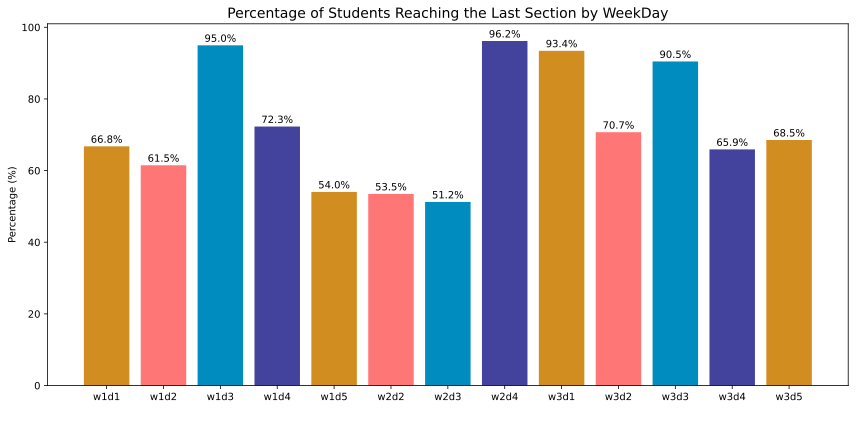

In [ ]:
sorted_sections = short_section_counts.groupby('WeekDay')['short_section'].apply(lambda x: sorted(x))

# Identify the last section for each WeekDay (no Bonus included)
last_sections = sorted_sections.apply(lambda x: x[-1] if x else None)

# Step 2: Calculate the number and percentage of students reaching the last section
last_section_counts = short_section_counts[short_section_counts['short_section'].isin(last_sections.values)]
last_section_counts = last_section_counts.merge(last_sections.rename('last_section'), on='WeekDay')

# Filter only rows corresponding to the last sections
last_section_counts = last_section_counts[last_section_counts['short_section'] == last_section_counts['last_section']]

# Add percentage of students reaching the last section
last_section_counts['percentage_last_section'] = (
    last_section_counts['count'] / total_students_per_weekday[last_section_counts['WeekDay']].values
) * 100

# Step 3: Create a bar chart for students reaching the last section
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    last_section_counts['WeekDay'],
    last_section_counts['percentage_last_section'],
    color=colors
)

# Annotate the bars with percentages
for i, percentage in enumerate(last_section_counts['percentage_last_section']):
    ax.text(i, percentage + 1, f"{percentage:.1f}%", ha='center')

# Add labels and title
ax.set_title('Percentage of Students Reaching the Last Section by WeekDay', fontsize=14)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel(' ')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Goals

goal1_intermediate
goal2_intermediate
goal3_intermediate

In the daily surveys these questions are asked only once.

In [ ]:
# Check in which day these questions are present.

# Goal 1: Do you feel this course is helping you progress towards your stated goal?
missing_goals = combined_df.groupby('WeekDay')['goal1_intermediate'].value_counts(normalize=True) *100
print(missing_goals)

WeekDay  goal1_intermediate       
w1d5     Agree                       60.14
         Strongly agree              25.00
         Neither disagree or agree   11.59
         Strongly disagree            2.17
         Disagree                     1.09
Name: proportion, dtype: float64


In [ ]:
# Goal 2: Considering your initial goal, how would you rate the relevancy of the course content so far?
missing_goal2 = combined_df.groupby('WeekDay')['goal2_intermediate'].value_counts(normalize=True) *100
print(missing_goal2)

WeekDay  goal2_intermediate 
w1d5     Very relevant         46.57
         Extremely relevant    28.16
         Moderately relevant   20.58
         Slightly relevant      4.69
Name: proportion, dtype: float64


In [ ]:
# Goal 3: How confident are you that you will achieve your goal by the end of this course?
missing_goal3 = combined_df.groupby('WeekDay')['goal3_intermediate'].value_counts(normalize=True) *100
print(missing_goal3)

WeekDay  goal3_intermediate  
w1d5     Moderately confident   41.52
         Very confident         30.32
         Extremely confident    14.44
         Slightly confident     11.55
         Not confident at all    2.17
Name: proportion, dtype: float64


At the end of the first week:

1. Over 80% of students reported that CN is helping them meeting their goals
2. 75% of students reported the course CN is relevant for their goals
3. Over 70% of students is confident that they will achieve their goals by the end of the course.

# LastQ

This field is speciflcally related to TAs and they assess this question daily. Not particularly useful to look into it a posteriori.

# TA concerns

TA concern questions is used during the course for pod check-ins.

In [ ]:
TAconcern = combined_df[combined_df['TAconcerns'].notna()].groupby('WeekDay').size().reset_index(name='count')
print(TAconcern)

  WeekDay  count
0    w1d3     54
1    w1d5     22
2    w2d1     29


# Project TA
This is a multiple choice question that is not present in each day.

In [ ]:
# combined_df['Project TA'].unique()

In [ ]:
ProjectTA = combined_df[combined_df['Project TA'].notna()].groupby('WeekDay').size().reset_index(name='count')
print(ProjectTA)

  WeekDay  count
0    w2d4    238
1    w3d1    229
2    w3d2    232
3    w3d3    203
4    w3d4    200
5    w3d5    174


In [ ]:
answer_labels = {
    'A': 'I learned from other project group members',
    'B': 'I learned from my project TA',
    'C': 'I learned from my regular TA',
    'D': 'I learned from a mentor',
    'E': 'I supported other members of my group members',
    'F': 'We made progress on our research project',
    'G': 'I learned from a professional development activity'
}

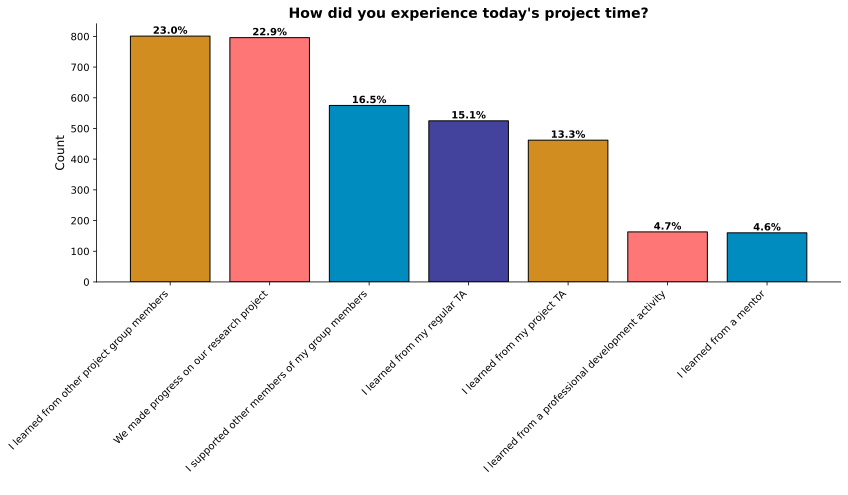

In [ ]:
# Fill missing values in 'Project TA' column with an empty string
combined_df['Project TA'] = combined_df['Project TA'].fillna('')

# Split the multiple-choice answers into individual responses
split_answers = combined_df['Project TA'].str.split(',')

# Count occurrences of each option
answer_counts = {}
for answers in split_answers:
    for answer in answers:
        if answer.strip():  # Ignore empty strings
            if answer in answer_counts:
                answer_counts[answer] += 1
            else:
                answer_counts[answer] = 1

# Calculate total responses for percentage calculation
total_responses = sum(answer_counts.values())

# Map the answers to their descriptive labels and calculate percentages
mapped_counts = {
    answer_labels[key]: (value, value / total_responses * 100)
    for key, value in answer_counts.items()
}

answer_df = pd.DataFrame(
    [(label, count, f"{percentage:.1f}%") for label, (count, percentage) in mapped_counts.items()],
    columns=['Answer', 'Count', 'Percentage']
)

# Sort the DataFrame by count
answer_df = answer_df.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 7))

#color = colors

bars = plt.bar(answer_df['Answer'], answer_df['Count'], color=colors, edgecolor='black')

# Add percentages on top of each bar
for bar, percentage in zip(bars, answer_df['Percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        percentage,
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("How did you experience today's project time?", fontsize=14, fontweight='bold')
plt.xlabel(' ')
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

plt.savefig('ProjectTA.png', dpi=400)
plt.show()
#files.download('ProjectTA.png')